## Importing the libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## Importing Libraries

In [2]:
main_df = pd.read_csv("data_labels_mainData.csv")

In [3]:
main_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Showing image of each cell type

In [4]:
def show_images(df):
    explore_df = df.groupby("cellTypeName").first()
    
    image_list = []
    image_names = []
    for ind, row in explore_df.iterrows():
        img = cv2.imread("patch_images/"+row["ImageName"])
        image_list.append(img)
        image_names.append(ind)
    
    fig = plt.figure(figsize=(10, 10))
    rows = 2
    columns = 2
    axis_list = []
    for i in range(explore_df.shape[0]):
        axis_list.append(plt.subplot(1,explore_df.shape[0],i+1))
                     
    for i,ax in enumerate(axis_list):
        ax.imshow(image_list[i])
        ax.set_title(image_names[i])

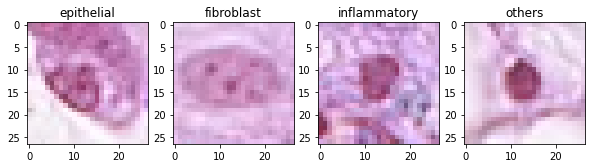

In [5]:
show_images(main_df)

In [6]:
def show_multiple_images(df, cellType):
    df = df[df["cellTypeName"] == cellType]
    explore_df = df.sample(5)
    
    image_list = []
    for ind, row in explore_df.iterrows():
        img = cv2.imread("patch_images/"+row["ImageName"])
        image_list.append(img)
    
    fig = plt.figure(figsize=(10, 10))
    axis_list = []
    for i in range(explore_df.shape[0]):
        axis_list.append(plt.subplot(1,explore_df.shape[0],i+1))
                     
    for i,ax in enumerate(axis_list):
        ax.imshow(image_list[i])
        ax.set_title(val)

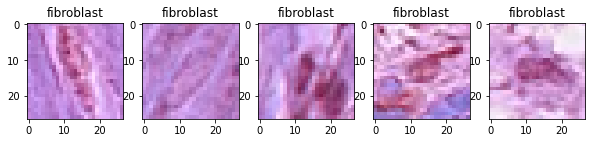

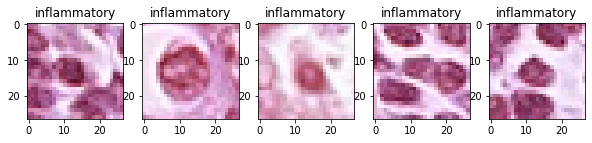

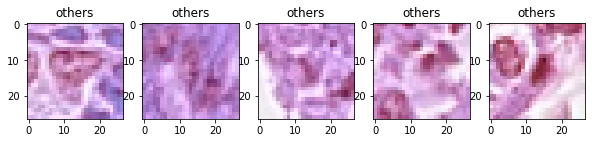

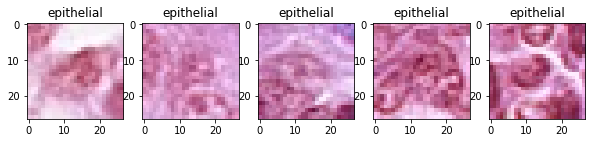

In [7]:
for val in main_df["cellTypeName"].unique():
    show_multiple_images(main_df, val)

Above image plot shows that - 
* For each cell type, there are representations of image. This would prove a crucial factor when developing the deep learning model, as the model has to learn from each representations of cell type.

Number of images for each cell type:


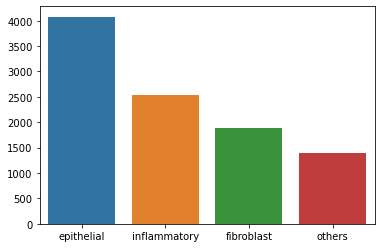

In [8]:
print("Number of images for each cell type:")

ax = sns.barplot(x=main_df["cellTypeName"].value_counts().index, y=main_df["cellTypeName"].value_counts().values, data=main_df)

The above bar plot, shows that the image classification model might do well for the epithelial cell type, as it contains close to 4000 images, double of fibroblast and others cell type.

Since this task, is to identify the images as cell type, we can remove the column IsCancerous, InstanceID and the patientID. But we can keep the patientid , because there are multiple records for one single patient Id. We can use this to stratify the train test split, making the split evenly distributed.

In [9]:
main_df.drop(columns = ["isCancerous", "InstanceID"], inplace=True)

In [10]:
main_df.head()

,patientID,ImageName,cellTypeName,cellType
0,1,22405.png,fibroblast,0
1,1,22406.png,fibroblast,0
2,1,22407.png,fibroblast,0
3,1,22408.png,fibroblast,0
4,1,22409.png,fibroblast,0


In [11]:
main_df.groupby("cellTypeName").first()

,patientID,ImageName,cellType
cellTypeName,,,
epithelial,5,276.png,2
fibroblast,1,22405.png,0
inflammatory,1,22417.png,1
others,1,22423.png,3


As per the above table, "Fibroblast" is represented as 0, "Inflammatory" as 1, "Epithelial" as 2 and "others" as 3. Since we have cellType, there is no need for cellTypeName

In [12]:
main_df.drop(columns = ["cellTypeName"], inplace = True)

In [13]:
main_df.head()

,patientID,ImageName,cellType
0,1,22405.png,0
1,1,22406.png,0
2,1,22407.png,0
3,1,22408.png,0
4,1,22409.png,0


In [14]:
def add_path(image):
    return "./patch_images/"+image

main_df["ImageName"] = main_df["ImageName"].apply(add_path)

In [15]:
main_df.head()

,patientID,ImageName,cellType
0,1,./patch_images/22405.png,0
1,1,./patch_images/22406.png,0
2,1,./patch_images/22407.png,0
3,1,./patch_images/22408.png,0
4,1,./patch_images/22409.png,0


In [16]:
main_df.shape

(9896, 3)

Let's split the dataset into train, valid and test. For the training purpose, we will divide the data into 20% for test and 25% validation data out of total.

In [20]:
train_data, test_data = train_test_split(main_df, test_size=0.20, random_state=9, stratify = main_df.patientID)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=9, stratify = train_data.patientID)

train_data.drop(columns = ["patientID"], inplace=True)
test_data.drop(columns = ["patientID"], inplace=True)
val_data.drop(columns = ["patientID"], inplace=True)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


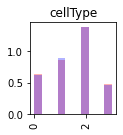

In [21]:
plt.figure(figsize=(20,20))

for i, col in enumerate(train_data.columns):

    if col != 'ImageName':
        plt.subplot(10,11,i+1)
        if train_data[col].dtypes != np.int64:
            plt.bar(train_data[col].value_counts().index.astype(str), 
                    train_data[col].value_counts().values/np.sum(train_data[col].value_counts().values), 
                    alpha=0.3, color='r')
            plt.bar(test_data[col].value_counts().index.astype(str), 
                    test_data[col].value_counts().values/np.sum(test_data[col].value_counts().values), 
                    alpha=0.3, color='b')
        else:
            plt.hist(train_data[col], alpha=0.3, color='r', density=True)
            plt.hist(test_data[col], alpha=0.3, color='b', density=True)

        plt.title(col)
        plt.xticks(rotation='vertical')

The above distribution of cell Type in each train, test and validatio data proves to be pretty much the same, indicating the right split ratio.

## Plot for showing the distribution of Accuracy and Loss on the train and validation data over number of epochs

In [22]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Generating Confusion Matrix and Classification Report

In [23]:
def generate_stats_cellType(generator,history):
    generator.reset()
    Y_pred = history.model.predict_generator(generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(generator.classes, y_pred))
    print('Classification Report')
    target_names = ['Fibroblast','Inflammatory','Epithelial', 'others']
    print(classification_report(generator.classes, y_pred, target_names=target_names))

## Image Generator for CellType

In [24]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
test_data['cellType'] = test_data['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


## Setting up basic MLP model 

In [ ]:
def set_NN_model(INPUT_DIM, HIDDEN_LAYER_DIM, OUTPUT_CLASSES, Activation = "sigmoid"):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation=Activation),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    
    return model

In [ ]:
def compile_model(model, Optimizer = "SGD", Metric = 'categorical_accuracy'):
    model.compile(optimizer=Optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[Metric])
    return model

In [ ]:
hidden_layer = [256,512,724]
input_dimension = (27,27,3)
output_dimension = 4
model_history_list = []

for val in hidden_layer:
    print("Building MLP for ",val," neurons in hidden layer")
    #Building the model
    model = set_NN_model(input_dimension, val, output_dimension)
    #Compiling the model
    model = compile_model(model)
    #Print model stats
    print(model.summary())
    print(tf.keras.utils.plot_model(model, show_shapes=True))
    #Using Early Stopping technique to stop if there is no change in validation loss after 5 epochs
    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=5,verbose=1,restore_best_weights=True)
    #Fit the train generator with validation data as validation generator data
    history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0, 
                                  callbacks = [monitor])
    #Plotting the graph for loss for training and validation data for n number of epochs, along with accuracy of the model
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Model Evaluation: ", str(model.evaluate(test_generator)))
    generate_stats_cellType(test_generator, history)
    model_history_list.append(history)
    print("*** End of training ***")

Looking at the above results, hidden layer with 512 neurons is out performing the other hyper parameters slightly. So we will go with the second model in the list of model history.

Now we will apply the deep learning model on the same dataset using cnn architecture

In [ ]:
label_names = {'Fibroblast' : 0, 'Inflammatory' : 1, 'Epithelial' : 2, 'others' : 3}

In [ ]:
# d_inv = {v: k for k, v in label_names.items()}
# plt.figure(figsize=(16,4))
# batches = 0
# for x,y in test_generator:
#         batches = batches + 1
#         y_hat = model.predict(x, verbose=0)
#         x = np.squeeze(x)
#         if batches < 5:
#             plt.subplot(1,5,batches)
#             plt.imshow(x)
#             plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
#         else:
#             break
        
#         plt.axis('off')

## Deep Learning Model

Since we have created the train, test and validation data generator, we can use the same for the Deep Learning Models as well.

In [25]:
OUTPUT_CLASSES = 4

In [26]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [27]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [31]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

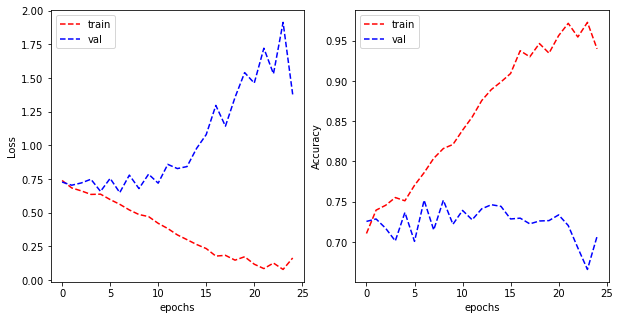

In [32]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Since the above graph is overfitting, we can use the following technique to reduce the overfitting:
1. Regularization values using L2
2. Dropout at the last layer
3. Learning rate of the model

In [60]:
def build_model(reg_lambda, dropout, learning_rate, dense_layer):
    model = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(val)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(val)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(val)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(val)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(val)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_layer, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
    model_history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model.evaluate(test_generator)))
        
    return model

Training for reg_lamda = 0.001  ,dropout= 0  ,learning_rate= 0.001  ,Neurons in dense layer= 128


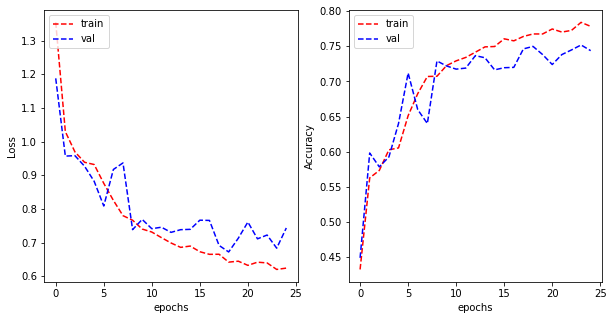

74/74 [==============================] - 2s 32ms/step - loss: 0.7139 - categorical_accuracy: 0.7545 0s - loss: 0.7030 - categorical_
Performance on test data:  [0.7139028906822205, 0.7545454502105713]
*** End of iteration ***

Training for reg_lamda = 0.001  ,dropout= 0  ,learning_rate= 0.01  ,Neurons in dense layer= 128


In [ ]:
reg_lambda = [0.001, 0.01, 0.1]
dropout = [0,0.2,0.5]
learning_rate = [0.001, 0.01, 0.05]
dense_layer = [128]

for reg in reg_lambda:
    for drop in dropout:
        for lr in learning_rate:
            for dl in dense_layer:
                print("Training for reg_lamda =",reg," ,dropout=",drop," ,learning_rate=",lr," ,Neurons in dense layer=",dl)
                
                build_model(reg, drop, lr, dl)
        
                print("*** End of iteration ***")
            
                print()